## Cityscapes: UNET Edge Detection & Faster R-CNN Object Detection
### Trains and evaluates UNET (boundary detection) and Faster R-CNN (object detection)
### on the preprocessed Cityscapes dataset, optimized for memory constraints.

In [ ]:
# Basic Setup and Imports
import os
import zipfile
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler

# Optional: Set for CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
### Data Preparation


# Mount Google Drive (if running in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # !! Adjust this path to your zip file in Google Drive !!
    zip_path = '/content/drive/MyDrive/Colab Notebooks/Sem_2_lab/preprocessed_cityscapes.zip'
except ModuleNotFoundError:
    print("Not running in Colab or Drive not available. Assuming data is local.")
    # !! Set this path if running locally !!
    zip_path = 'preprocessed_cityscapes.zip'

extract_path = '/content/preprocessed_cityscapes' if 'google.colab' in str(get_ipython()) else 'preprocessed_cityscapes'
os.makedirs(extract_path, exist_ok=True)

# Extract the dataset
if os.path.exists(zip_path):
    print(f"Extracting {zip_path} to {extract_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Error: Zip file not found at {zip_path}. Please check the path.")

# Define data directories
image_dir = os.path.join(extract_path, 'images')
boundary_mask_dir = os.path.join(extract_path, 'boundaries')
full_mask_dir = os.path.join(extract_path, 'masks') # For Faster R-CNN

# Verify directories
if not os.path.isdir(image_dir) or not os.path.isdir(boundary_mask_dir) or not os.path.isdir(full_mask_dir):
    print("Error: Data directories not found after extraction.")
else:
    print("Data directories verified.")
    print(f"Found {len(os.listdir(image_dir))} images.")
    print(f"Found {len(os.listdir(boundary_mask_dir))} boundary masks.")
    print(f"Found {len(os.listdir(full_mask_dir))} full masks.")


Mounted at /content/drive
Extracting /content/drive/MyDrive/Colab Notebooks/Sem_2_lab/preprocessed_cityscapes.zip to /content/preprocessed_cityscapes...
Extraction complete.
Data directories verified.
Found 2975 images.
Found 2975 boundary masks.
Found 2975 full masks.


## UNET for Boundary / Edge Detection

In [ ]:
# --- UNET Model Definition ---
class UNetBoundary(nn.Module):
    """ UNET architecture for boundary detection (outputs logits). """
    def __init__(self, in_channels=3, out_channels=1):
        super(UNetBoundary, self).__init__()

        def conv_block(in_c, out_c):
            # Standard UNET conv block with BatchNorm
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        # Encoder path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512) # Bottleneck

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder path with skip connections
        self.dec3 = conv_block(512 + 256, 256)
        self.dec2 = conv_block(256 + 128, 128)
        self.dec1 = conv_block(128 + 64, 64)

        # Final 1x1 convolution for output channel
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder with skip connections
        d3 = self.up(e4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1) # Output logits
        return out

In [ ]:
# --- UNET Dataset ---
class CityscapesBoundaryDataset(Dataset):
    """ Loads Cityscapes images and boundary masks. """
    def __init__(self, image_paths, boundary_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.boundary_paths = boundary_paths
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            mask = Image.open(self.boundary_paths[idx]).convert('L')

            if self.transform:
                img = self.transform(img)

            if self.mask_transform:
                 mask = self.mask_transform(mask)
            else:
                 mask = transforms.ToTensor()(mask) # Default transform

            mask = mask.float() # Ensure mask is float

        except Exception as e:
            print(f"Error loading data index {idx} ({self.image_paths[idx]}): {e}")
            return None, None # Return None on error, handled by collate_fn

        return img, mask

In [ ]:
# --- UNET Training Function (Chunked) ---
def train_unet_chunk(model, image_paths, boundary_paths, device, model_path, num_epochs=3, batch_size=8, accumulation_steps=4, learning_rate=1e-4):
    """ Trains UNET on a data chunk with mixed precision and gradient accumulation. """
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    mask_transform = transforms.Compose([transforms.ToTensor()])
    dataset = CityscapesBoundaryDataset(image_paths, boundary_paths, transform=img_transform, mask_transform=mask_transform)

    # Collate function to filter out None items from dataset errors
    def collate_fn_filter_none(batch):
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch: return None, None
        return torch.utils.data.dataloader.default_collate(batch)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn_filter_none)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss() # Use with logits output
    scaler = GradScaler(enabled=(device.type == 'cuda')) # For mixed precision

    print(f"Starting training on {len(dataset)} images for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        processed_batches = 0
        optimizer.zero_grad()

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100, unit='batch')
        for step, batch_data in enumerate(pbar):
            if batch_data[0] is None: continue # Skip bad batches

            images, masks = batch_data
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            with autocast(enabled=(device.type == 'cuda')): # Mixed precision context
                outputs = model(images)
                loss = criterion(outputs, masks)
                if torch.isnan(loss):
                    print(f"NaN loss detected at step {step}! Skipping batch.")
                    continue
                loss = loss / accumulation_steps # Scale loss for accumulation

            scaler.scale(loss).backward() # Scale loss, calculate gradients

            # Optimizer step after accumulating gradients
            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(loader):
                # Optional: Gradient Clipping
                # scaler.unscale_(optimizer)
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            batch_loss = loss.item() * accumulation_steps
            total_loss += batch_loss
            processed_batches += 1
            pbar.set_postfix(loss=f"{batch_loss:.4f}")

            del images, masks, outputs, loss, batch_data
            if device.type == 'cuda': torch.cuda.empty_cache()

        if processed_batches > 0:
             avg_loss = total_loss / processed_batches
             print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
        else:
             print(f"Epoch {epoch+1} had no processed batches.")

    torch.save(model.state_dict(), model_path)
    print(f"Checkpoint saved to {model_path}")

In [ ]:
# --- UNET Evaluation Metrics (IoU, Dice) ---
def compute_iou_and_dice(preds, targets, threshold=0.5, smooth=1e-6):
    """ Computes IoU and Dice Score for binary segmentation. """
    preds = torch.sigmoid(preds) # Convert logits to probabilities
    preds_bin = (preds > threshold).float()
    targets_bin = (targets > 0.5).float()

    if preds_bin.ndim == 4: preds_bin = preds_bin.squeeze(1)
    if targets_bin.ndim == 4: targets_bin = targets_bin.squeeze(1)

    intersection = (preds_bin * targets_bin).sum(dim=(1, 2))
    pred_sum = preds_bin.sum(dim=(1, 2))
    target_sum = targets_bin.sum(dim=(1, 2))
    union = pred_sum + target_sum

    iou = (intersection + smooth) / (union - intersection + smooth)
    dice = (2 * intersection + smooth) / (union + smooth)
    return iou.mean().item(), dice.mean().item()

def evaluate_unet(model, dataloader, device, threshold=0.5):
    """ Evaluates the UNET model using IoU and Dice score. """
    model.eval()
    total_iou, total_dice = 0.0, 0.0
    num_batches = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating UNET", ncols=100, unit='batch')
        for batch_data in pbar:
            if batch_data[0] is None: continue
            images, masks = batch_data
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True) # Keep masks on GPU for consistency if possible

            outputs = model(images)
            # Compute metrics on CPU to avoid potential GPU memory issues during aggregation
            iou, dice = compute_iou_and_dice(outputs.cpu(), masks.cpu(), threshold=threshold)

            total_iou += iou
            total_dice += dice
            num_batches += 1
            pbar.set_postfix(iou=f"{iou:.4f}", dice=f"{dice:.4f}")

            del images, masks, outputs, batch_data
            if device.type == 'cuda': torch.cuda.empty_cache()

    avg_iou = total_iou / num_batches if num_batches > 0 else 0
    avg_dice = total_dice / num_batches if num_batches > 0 else 0
    print(f"\nEvaluation Results - Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")
    return avg_iou, avg_dice

In [ ]:
# --- UNET Visualization ---
def visualize_unet_predictions(model, dataset, device, num_images=5, threshold=0.5):
    """ Visualizes UNET predictions against ground truth. """
    model.eval()
    num_images = min(num_images, len(dataset))
    if num_images == 0: return
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    if num_images == 1: axes = np.expand_dims(axes, axis=0)

    # Inverse normalization transform for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    indices = np.random.choice(len(dataset), num_images, replace=False)
    print(f"Visualizing {num_images} UNET predictions...")

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, mask = dataset[idx]
            if img is None: continue
            img_tensor = img.unsqueeze(0).to(device)

            output = model(img_tensor)
            pred_prob = torch.sigmoid(output)
            pred_mask = (pred_prob > threshold).float().cpu().squeeze(0)

            # Prepare images for display
            img_display = TF.to_pil_image(inv_normalize(img).cpu())
            mask_display = TF.to_pil_image(mask.cpu())
            pred_display = TF.to_pil_image(pred_mask)

            # Plot
            axes[i, 0].imshow(img_display); axes[i, 0].set_title("Input Image"); axes[i, 0].axis('off')
            axes[i, 1].imshow(mask_display, cmap='gray'); axes[i, 1].set_title("Ground Truth"); axes[i, 1].axis('off')
            axes[i, 2].imshow(pred_display, cmap='gray'); axes[i, 2].set_title("Prediction"); axes[i, 2].axis('off')

            del img_tensor, output, pred_prob, pred_mask
            if device.type == 'cuda': torch.cuda.empty_cache()

    plt.tight_layout()
    plt.show()

### UNET Training Execution

In [ ]:
# --- UNET Main Training Loop ---
def run_unet_training():
    print("--- Starting UNET Training ---")
    # --- Configuration ---
    unet_model_path = 'unet_boundary_checkpoint.pth'
    unet_num_epochs_per_chunk = 40
    unet_batch_size = 8         # Adjust based on GPU VRAM
    unet_accumulation_steps = 4 # Effective batch size = batch_size * accumulation_steps
    unet_learning_rate = 1e-3
    unet_chunk_size = 1500      # Images per training chunk
    unet_eval_chunk_size = 200  # Images for evaluation subset
    unet_vis_count = 5

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Data Paths ---
    all_image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))
    all_boundary_paths = sorted(glob.glob(os.path.join(boundary_mask_dir, '*.png')))
    if len(all_image_paths) != len(all_boundary_paths) or not all_image_paths:
        print("Error: Image/mask mismatch or no data found.")
        return
    print(f"Total image/mask pairs found: {len(all_image_paths)}")

    # --- Model Initialization ---
    model = UNetBoundary(in_channels=3, out_channels=1)
    if os.path.exists(unet_model_path):
        try:
            model.load_state_dict(torch.load(unet_model_path, map_location=device))
            print(f"Loaded UNET checkpoint: {unet_model_path}")
        except Exception as e:
            print(f"Could not load checkpoint: {e}. Starting fresh.")
    model.to(device)

    # --- Training Loop (Chunked) ---
    num_chunks = (len(all_image_paths) + unet_chunk_size - 1) // unet_chunk_size
    print(f"Starting training in {num_chunks} chunks...")
    for i in range(0, len(all_image_paths), unet_chunk_size):
        chunk_start, chunk_end = i, min(i + unet_chunk_size, len(all_image_paths))
        chunk_images = all_image_paths[chunk_start:chunk_end]
        chunk_masks = all_boundary_paths[chunk_start:chunk_end]
        print(f"\n--- Training UNET Chunk {i//unet_chunk_size + 1}/{num_chunks} ({len(chunk_images)} images) ---")
        train_unet_chunk(model, chunk_images, chunk_masks, device, unet_model_path,
                         num_epochs=unet_num_epochs_per_chunk, batch_size=unet_batch_size,
                         accumulation_steps=unet_accumulation_steps, learning_rate=unet_learning_rate)
    print("\n--- UNET Training Finished ---")

    # --- Evaluation ---
    print("\n--- Evaluating UNET Model ---")
    eval_image_paths = all_image_paths[:unet_eval_chunk_size]
    eval_mask_paths = all_boundary_paths[:unet_eval_chunk_size]
    eval_img_transform = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    eval_mask_transform = transforms.Compose([transforms.ToTensor()])
    eval_dataset = CityscapesBoundaryDataset(eval_image_paths, eval_mask_paths, transform=eval_img_transform, mask_transform=eval_mask_transform)

    def collate_fn_filter_none(batch): # Reusable collate fn
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch: return None, None
        return torch.utils.data.dataloader.default_collate(batch)

    eval_loader = DataLoader(eval_dataset, batch_size=unet_batch_size * 2, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn_filter_none)
    evaluate_unet(model, eval_loader, device)

    # --- Visualization ---
    print("\n--- Visualizing UNET Predictions ---")
    # Dataset for visualization (no normalization on image)
    vis_img_transform = transforms.Compose([transforms.ToTensor()])
    vis_mask_transform = transforms.Compose([transforms.ToTensor()])
    # Dataset for model input during visualization (needs normalization)
    vis_eval_dataset = CityscapesBoundaryDataset(all_image_paths, all_boundary_paths, transform=eval_img_transform, mask_transform=eval_mask_transform)

    if os.path.exists(unet_model_path): # Ensure latest model is loaded
        model.load_state_dict(torch.load(unet_model_path, map_location=device))
    model.to(device)
    visualize_unet_predictions(model, vis_eval_dataset, device, num_images=unet_vis_count)

--- Starting UNET Training ---
Using device: cuda
Total image/mask pairs found: 2975
Loaded UNET checkpoint: unet_boundary_checkpoint.pth
Starting training in 2 chunks...

--- Training UNET Chunk 1/2 (1500 images) ---
Starting training on 1500 images for 40 epochs...


<ipython-input-32-b6f3f9e03f70>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda')) # For mixed precision


Epoch 1/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

<ipython-input-32-b6f3f9e03f70>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')): # Mixed precision context


Epoch 1 Average Loss: 0.3479


Epoch 2/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 2 Average Loss: 0.2662


Epoch 3/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 3 Average Loss: 0.2502


Epoch 4/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 4 Average Loss: 0.2435


Epoch 5/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 5 Average Loss: 0.2394


Epoch 6/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 6 Average Loss: 0.2363


Epoch 7/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 7 Average Loss: 0.2338


Epoch 8/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 8 Average Loss: 0.2319


Epoch 9/40:   0%|                                                        | 0/188 [00:00<?, ?batch/s]

Epoch 9 Average Loss: 0.2299


Epoch 10/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 10 Average Loss: 0.2284


Epoch 11/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 11 Average Loss: 0.2272


Epoch 12/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 12 Average Loss: 0.2250


Epoch 13/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 13 Average Loss: 0.2248


Epoch 14/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 14 Average Loss: 0.2234


Epoch 15/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 15 Average Loss: 0.2217


Epoch 16/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 16 Average Loss: 0.2213


Epoch 17/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 17 Average Loss: 0.2202


Epoch 18/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 18 Average Loss: 0.2202


Epoch 19/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 19 Average Loss: 0.2188


Epoch 20/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 20 Average Loss: 0.2178


Epoch 21/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 21 Average Loss: 0.2163


Epoch 22/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 22 Average Loss: 0.2155


Epoch 23/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 23 Average Loss: 0.2151


Epoch 24/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 24 Average Loss: 0.2146


Epoch 25/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 25 Average Loss: 0.2129


Epoch 26/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 26 Average Loss: 0.2117


Epoch 27/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 27 Average Loss: 0.2111


Epoch 28/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 28 Average Loss: 0.2102


Epoch 29/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 29 Average Loss: 0.2104


Epoch 30/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 30 Average Loss: 0.2090


Epoch 31/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 31 Average Loss: 0.2080


Epoch 32/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 32 Average Loss: 0.2070


Epoch 33/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 33 Average Loss: 0.2058


Epoch 34/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 34 Average Loss: 0.2047


Epoch 35/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 35 Average Loss: 0.2034


Epoch 36/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 36 Average Loss: 0.2016


Epoch 37/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 37 Average Loss: 0.2012


Epoch 38/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 38 Average Loss: 0.2000


Epoch 39/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 39 Average Loss: 0.1993


Epoch 40/40:   0%|                                                       | 0/188 [00:00<?, ?batch/s]

Epoch 40 Average Loss: 0.1965
Checkpoint saved to unet_boundary_checkpoint.pth

--- Training UNET Chunk 2/2 (1475 images) ---
Starting training on 1475 images for 40 epochs...


Epoch 1/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 1 Average Loss: 0.2161


Epoch 2/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 2 Average Loss: 0.2117


Epoch 3/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 3 Average Loss: 0.2083


Epoch 4/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 4 Average Loss: 0.2073


Epoch 5/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 5 Average Loss: 0.2057


Epoch 6/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 6 Average Loss: 0.2029


Epoch 7/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 7 Average Loss: 0.2017


Epoch 8/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 8 Average Loss: 0.1993


Epoch 9/40:   0%|                                                        | 0/185 [00:00<?, ?batch/s]

Epoch 9 Average Loss: 0.1975


Epoch 10/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 10 Average Loss: 0.1951


Epoch 11/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 11 Average Loss: 0.1924


Epoch 12/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 12 Average Loss: 0.1900


Epoch 13/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 13 Average Loss: 0.1879


Epoch 14/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 14 Average Loss: 0.1847


Epoch 15/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 15 Average Loss: 0.1816


Epoch 16/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 16 Average Loss: 0.1779


Epoch 17/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 17 Average Loss: 0.1744


Epoch 18/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 18 Average Loss: 0.1697


Epoch 19/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 19 Average Loss: 0.1668


Epoch 20/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 20 Average Loss: 0.1620


Epoch 21/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 21 Average Loss: 0.1576


Epoch 22/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 22 Average Loss: 0.1528


Epoch 23/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 23 Average Loss: 0.1497


Epoch 24/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 24 Average Loss: 0.1447


Epoch 25/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 25 Average Loss: 0.1405


Epoch 26/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 26 Average Loss: 0.1371


Epoch 27/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 27 Average Loss: 0.1329


Epoch 28/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 28 Average Loss: 0.1270


Epoch 29/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 29 Average Loss: 0.1250


Epoch 30/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 30 Average Loss: 0.1203


Epoch 31/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 31 Average Loss: 0.1175


Epoch 32/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 32 Average Loss: 0.1146


Epoch 33/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 33 Average Loss: 0.1107


Epoch 34/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 34 Average Loss: 0.1066


Epoch 35/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 35 Average Loss: 0.1040


Epoch 36/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 36 Average Loss: 0.1009


Epoch 37/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 37 Average Loss: 0.0975


Epoch 38/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 38 Average Loss: 0.0962


Epoch 39/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 39 Average Loss: 0.0934


Epoch 40/40:   0%|                                                       | 0/185 [00:00<?, ?batch/s]

Epoch 40 Average Loss: 0.0912
Checkpoint saved to unet_boundary_checkpoint.pth

--- UNET Training Finished ---

--- Evaluating UNET Model ---


Evaluating UNET:   0%|                                                    | 0/13 [00:00<?, ?batch/s]


Evaluation Results - Avg IoU: 0.2816, Avg Dice: 0.4309

--- Visualizing UNET Predictions ---
Visualizing 5 UNET predictions...


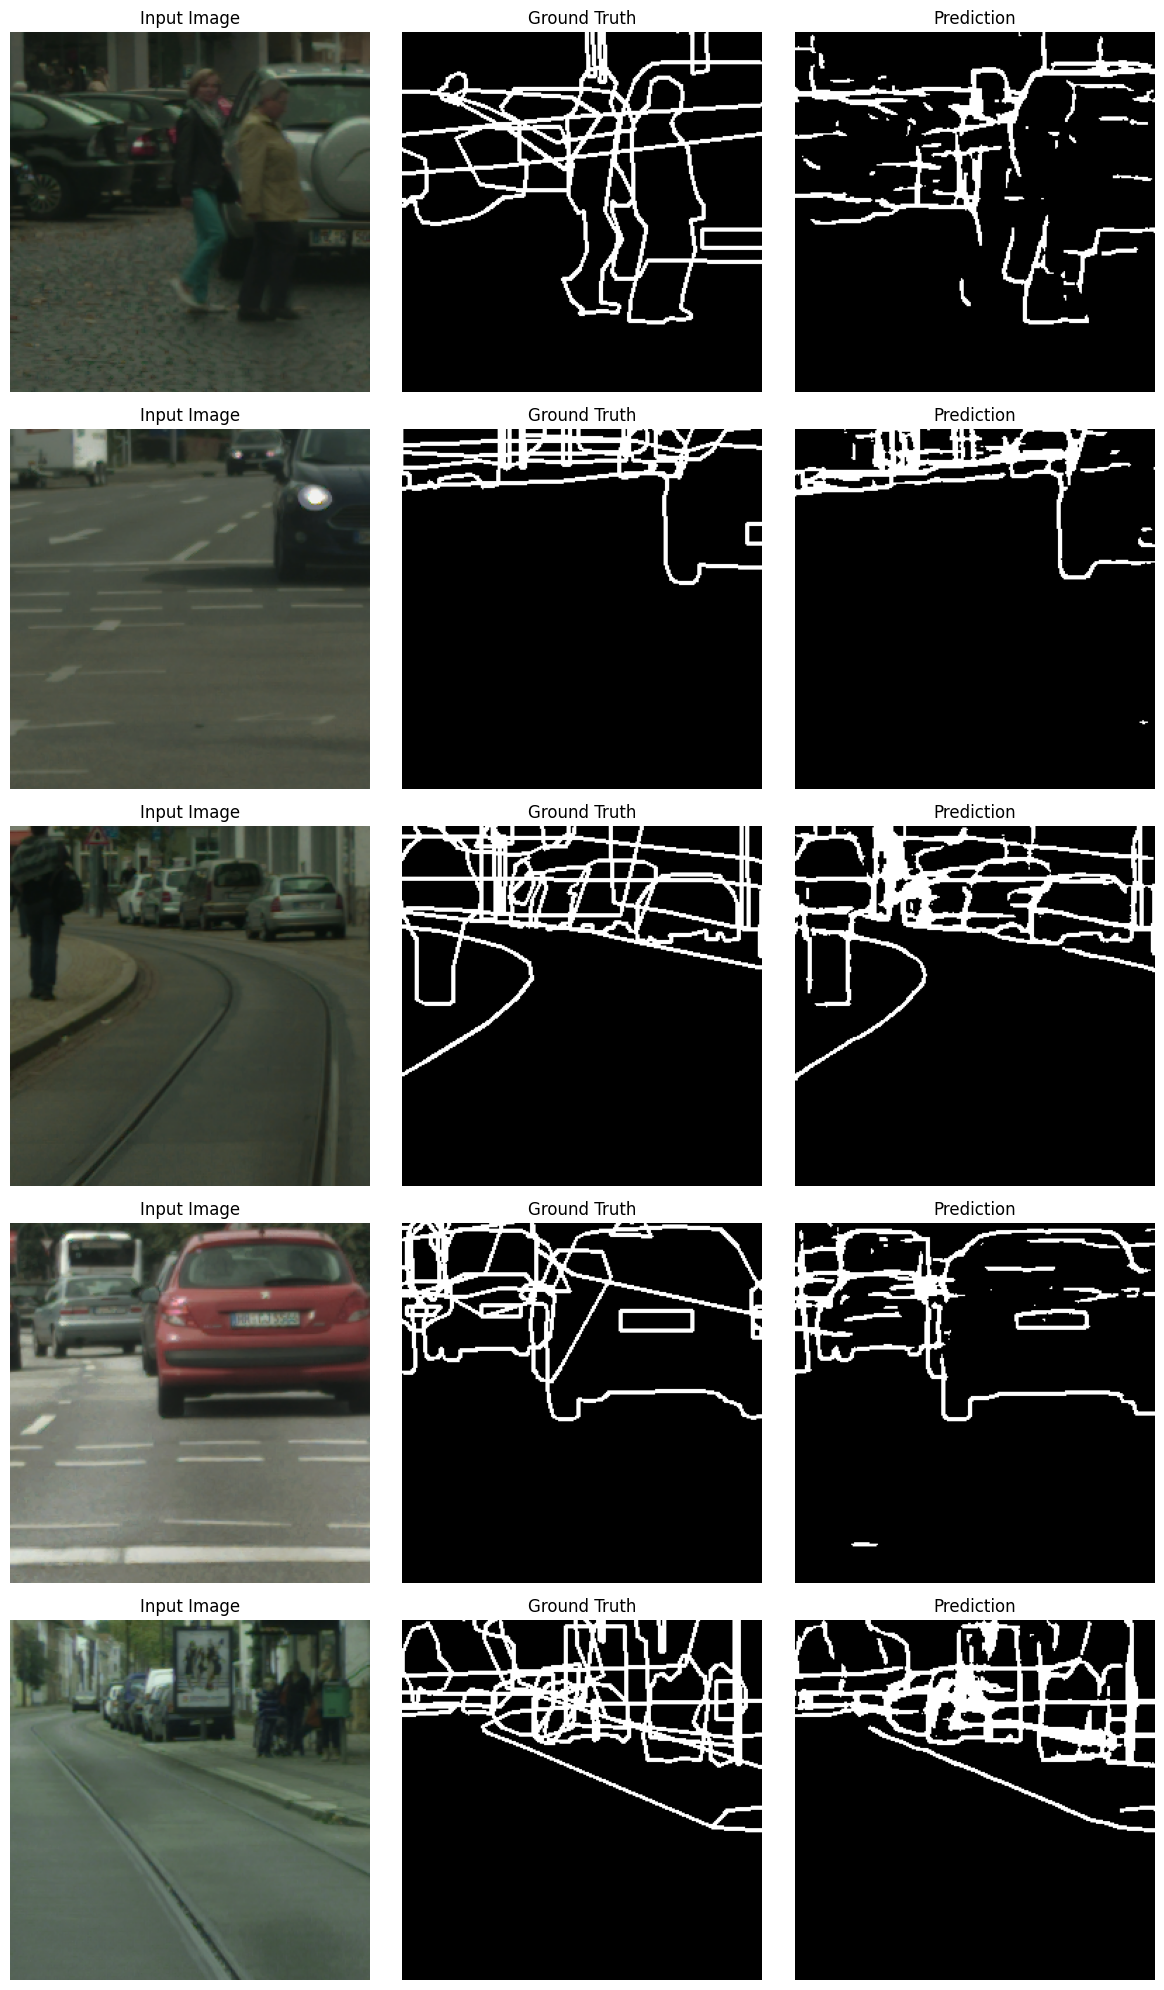

In [ ]:
# Run UNET pipeline
run_unet_training()